In [ ]:
%pip install kagglehub

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
SEED = 101 # for reproducibility

In [ ]:
import kagglehub

path = kagglehub.dataset_download("apurboshahidshawon/weatherdatabangladesh")
print(path)

100%|██████████| 89.7k/89.7k [00:00<00:00, 44.5MB/s]

Extracting files...
/root/.cache/kagglehub/datasets/apurboshahidshawon/weatherdatabangladesh/versions/2


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

file_name = os.path.join(path, "Weather_Data.csv")
df = pd.read_csv(file_name)

In [ ]:
# Can already get 75% accuracy by just predicting no --> really high precision
print(sum(df['RainToday'] == 'Yes'), sum(df['RainToday'] == 'No'))


849 2422


# Standardizing the data

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def scale(train_features, test_features) -> None:
  sc = StandardScaler()
  train_scaled = sc.fit_transform(train_features)
  test_scaled = sc.transform(test_features)
  return train_scaled, test_scaled


def preprocessing(df, target_feature):
    df = df.copy()
    df.drop('Date', axis=1, inplace=True)
    df['AvgTemp'] = (df['MinTemp'] + df['MaxTemp'] + df['Temp9am'] + df['Temp3pm']) / 4
    if target_feature == 'RainToday':
        df.drop('Rainfall', axis=1, inplace=True)
    df['RainToday'] = df['RainToday'].replace({'No': 0, 'Yes': 1})
    df = pd.get_dummies(df)

    labels = np.array(df[target_feature])
    features = np.array(df.drop(target_feature, axis=1))

    train_features, test_features, train_labels, test_labels = train_test_split(
        features, labels, test_size=0.35, random_state=SEED
    )

    train_features, test_features = scale(train_features, test_features)

    return train_features, test_features, train_labels, test_labels


In [ ]:
train_features, test_features, train_labels, test_labels = preprocessing(df, 'RainToday')

<ipython-input-8-3c7ed89b9853>:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['RainToday'] = df['RainToday'].replace({'No': 0, 'Yes': 1})


# Custom Model Wrapper

In [ ]:
class MetricResult():
  def __init__(self, predictions, labels, name: str):
    assert(len(predictions) == len(labels))
    self.accuracy = np.sum(predictions == labels) / len(labels)
    self.precision = np.sum((predictions == 1) & (labels == 1)) / np.sum(predictions == 1)
    self.recall = np.sum((predictions == 1) & (labels == 1)) / np.sum(labels == 1)
    self.f1_score = 2 * (self.precision * self.recall) / (self.precision + self.recall)
    self.name = name

  def __str__(self):
    return f"Results for {self.name}\nAccuracy: {self.accuracy}\nPrecision: {self.precision}\nRecall: {self.recall}\nF1 Score: {self.f1_score}\n"

Note: first run the angular calibration cell

In [ ]:
from typing import Optional
def wrap_calibration(raw_model, calibrated_method: Optional[str]):
  if calibrated_method is None:
      return raw_model
  if calibrated_method == "sigmoid" or calibrated_method == "isotonic":
      return CalibratedClassifierCV(raw_model, method=calibrated_method)
  if calibrated_method == "angular":
      return AngularCalibrator(raw_model)
  raise NotImplementedError(f"Calibration method {calibrated_method} not implemented")

In [ ]:
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay, calibration_curve

class BaseLearner():
  def __init__(self, name, model, train_features, test_features, train_labels, test_labels, calibrated_method=None):
      self.name = name
      self.raw_model = model
      if calibrated_method is not None:
        self.name = self.name + f" with {calibrated_method} calibration"
        self.model = wrap_calibration(model, calibrated_method)
      else:
        self.model = self.raw_model
      self.train_features = train_features
      self.test_features = test_features
      self.train_labels = train_labels
      self.test_labels = test_labels
      self.trained = False
      self.predictions = None

  def fit(self):
      if isinstance(self.model, AngularCalibrator):
          # reserve 20% train set for sign estimation
          n = len(self.train_features)
          split = int(0.8 * n)
          X_tr, y_tr = self.train_features[:split], self.train_labels[:split]
          X_sign, y_sign = self.train_features[split:], self.train_labels[split:]
          self.model.fit(X_tr, y_tr, X_sign=X_sign, y_sign=y_sign)
      else:
          self.model.fit(self.train_features, self.train_labels)
      self.trained = True

  def predict(self):
      if not self.trained:
        self.fit()
      return self.model.predict(self.test_features)

  def run_and_score(self)->MetricResult:
      if self.predictions is None:
        self.predictions = self.predict()
      return MetricResult(self.predictions, self.test_labels, self.name)

  def display_reliability(self, n_bins=10):
    if not self.trained:
        self.fit()
        self.trained = True

    y_prob = self.model.predict_proba(self.test_features)[:, 1]
    prob_true, prob_pred = calibration_curve(self.test_labels, y_prob, n_bins=n_bins)

    plt.figure(figsize=(6, 6))
    # Plot the perfect calibration line
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

    # Plot your model's calibration curve
    plt.plot(prob_pred, prob_true, marker='o', color="#A51C30", linewidth=2.5)

    plt.xlabel("Mean predicted probability", fontsize=17)
    plt.ylabel("Fraction of positives", fontsize=17)

    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{self.name}.png")
    plt.close()


In [ ]:
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, Perceptron, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


MODELS = {
    "LogReg": LogisticRegression(max_iter=1000000, random_state=SEED),
    "KNN": KNeighborsClassifier(n_neighbors=11, weights='distance'),
    "DT": DecisionTreeClassifier(random_state = SEED),
    "SVC": SVC(kernel='linear', probability=True, random_state=SEED),
    "RF": RandomForestClassifier(n_estimators = 900, random_state = SEED),
    "PAC": PassiveAggressiveClassifier(max_iter=1000000, random_state=SEED),
    "RC": RidgeClassifier(max_iter=1000000, random_state=SEED),
    "Perceptron": Perceptron(random_state=SEED)
}
OG_MODELS = {name: MODELS[name] for name in ["LogReg", "KNN", "DT", "SVC", "RF"]}

# Base Learner Experiments

In [ ]:
print(BaseLearner("Logistic Regression", MODELS["LogReg"], train_features, test_features, train_labels, test_labels).run_and_score())

print(BaseLearner("Logistic Regression", MODELS["LogReg"], train_features, test_features, train_labels, test_labels, calibrated_method="sigmoid").run_and_score())

print(BaseLearner("Logistic Regression", MODELS["LogReg"], train_features, test_features, train_labels, test_labels, calibrated_method="isotonic").run_and_score())

print(BaseLearner("Logistic Regression", MODELS["LogReg"], train_features, test_features, train_labels, test_labels, calibrated_method="angular").run_and_score())


Results for Logistic Regression
Accuracy: 0.8218340611353712
Precision: 0.70995670995671
Recall: 0.5448504983388704
F1 Score: 0.6165413533834587

Results for Logistic Regression with sigmoid calibration
Accuracy: 0.8218340611353712
Precision: 0.7276995305164319
Recall: 0.5149501661129569
F1 Score: 0.603112840466926

Results for Logistic Regression with isotonic calibration
Accuracy: 0.8253275109170306
Precision: 0.726457399103139
Recall: 0.5382059800664452
F1 Score: 0.6183206106870228

Results for Logistic Regression with angular calibration
Accuracy: 0.8270742358078602
Precision: 0.708502024291498
Recall: 0.5813953488372093
F1 Score: 0.6386861313868614



In [ ]:
print(BaseLearner("KNN", MODELS["KNN"], train_features, test_features, train_labels, test_labels).run_and_score())

print(BaseLearner("KNN", MODELS["KNN"], train_features, test_features, train_labels, test_labels, calibrated_method="sigmoid").run_and_score())

print(BaseLearner("KNN", MODELS["KNN"], train_features, test_features, train_labels, test_labels, calibrated_method="isotonic").run_and_score())

Results for KNN
Accuracy: 0.7799126637554585
Precision: 0.6762589928057554
Recall: 0.3122923588039867
F1 Score: 0.4272727272727272

Results for KNN with sigmoid calibration
Accuracy: 0.7781659388646288
Precision: 0.6358381502890174
Recall: 0.3654485049833887
F1 Score: 0.46413502109704646

Results for KNN with isotonic calibration
Accuracy: 0.7746724890829695
Precision: 0.6080402010050251
Recall: 0.4019933554817276
F1 Score: 0.48400000000000004



In [ ]:
print(BaseLearner("Decision Tree", MODELS["DT"], train_features, test_features, train_labels, test_labels).run_and_score())

# ***Very interesting finding
print(BaseLearner("Decision Tree", MODELS["DT"], train_features, test_features, train_labels, test_labels, calibrated_method="sigmoid").run_and_score())

print(BaseLearner("Decision Tree", MODELS["DT"], train_features, test_features, train_labels, test_labels, calibrated_method="isotonic").run_and_score())

Results for Decision Tree
Accuracy: 0.748471615720524
Precision: 0.52
Recall: 0.5614617940199336
F1 Score: 0.5399361022364217

Results for Decision Tree with sigmoid calibration
Accuracy: 0.7921397379912664
Precision: 0.8620689655172413
Recall: 0.24916943521594684
F1 Score: 0.38659793814432986

Results for Decision Tree with isotonic calibration
Accuracy: 0.7921397379912664
Precision: 0.8620689655172413
Recall: 0.24916943521594684
F1 Score: 0.38659793814432986



In [ ]:
print(BaseLearner("Support Vector Classifier", MODELS["SVC"], train_features, test_features, train_labels, test_labels).run_and_score())

print(BaseLearner("Support Vector Classifier", MODELS["SVC"], train_features, test_features, train_labels, test_labels, calibrated_method="sigmoid").run_and_score())

print(BaseLearner("Support Vector Classifier", MODELS["SVC"], train_features, test_features, train_labels, test_labels, calibrated_method="isotonic").run_and_score())

print(BaseLearner("Support Vector Classifier", MODELS["SVC"], train_features, test_features, train_labels, test_labels, calibrated_method="angular").run_and_score())

Results for Support Vector Classifier
Accuracy: 0.8270742358078602
Precision: 0.7395348837209302
Recall: 0.5282392026578073
F1 Score: 0.6162790697674418

Results for Support Vector Classifier with sigmoid calibration
Accuracy: 0.8244541484716157
Precision: 0.7450980392156863
Recall: 0.5049833887043189
F1 Score: 0.601980198019802

Results for Support Vector Classifier with isotonic calibration
Accuracy: 0.8253275109170306
Precision: 0.7439613526570048
Recall: 0.5116279069767442
F1 Score: 0.6062992125984252

Results for Support Vector Classifier with angular calibration
Accuracy: 0.8305676855895197
Precision: 0.73568281938326
Recall: 0.5548172757475083
F1 Score: 0.6325757575757575



In [ ]:
print(BaseLearner("Random Forest", MODELS["RF"], train_features, test_features, train_labels, test_labels).run_and_score())

# RF has its calibration trade off precision for recall (above diagonal)
print(BaseLearner("Random Forest", MODELS["RF"], train_features, test_features, train_labels, test_labels, calibrated_method="sigmoid").run_and_score())

print(BaseLearner("Random Forest", MODELS["RF"], train_features, test_features, train_labels, test_labels, calibrated_method="isotonic").run_and_score())


Results for Random Forest
Accuracy: 0.8323144104803494
Precision: 0.7766497461928934
Recall: 0.5083056478405316
F1 Score: 0.6144578313253012

Results for Random Forest with sigmoid calibration
Accuracy: 0.8331877729257642
Precision: 0.7696078431372549
Recall: 0.521594684385382
F1 Score: 0.6217821782178219

Results for Random Forest with isotonic calibration
Accuracy: 0.8253275109170306
Precision: 0.730593607305936
Recall: 0.53156146179402
F1 Score: 0.6153846153846154



In [ ]:
print(BaseLearner("Passive-Aggressive Classifier", MODELS["PAC"], train_features, test_features, train_labels, test_labels).run_and_score())

print(BaseLearner("Passive-Aggressive Classifier", MODELS["PAC"], train_features, test_features, train_labels, test_labels, calibrated_method="sigmoid").run_and_score())

print(BaseLearner("Passive-Aggressive Classifier", MODELS["PAC"], train_features, test_features, train_labels, test_labels, calibrated_method="isotonic").run_and_score())

print(BaseLearner("Passive-Aggressive Classifier", MODELS["PAC"], train_features, test_features, train_labels, test_labels, calibrated_method="angular").run_and_score())

Results for Passive-Aggressive Classifier
Accuracy: 0.7510917030567685
Precision: 0.5248447204968945
Recall: 0.5614617940199336
F1 Score: 0.5425361155698234

Results for Passive-Aggressive Classifier with sigmoid calibration
Accuracy: 0.8026200873362446
Precision: 0.7450980392156863
Recall: 0.3787375415282392
F1 Score: 0.5022026431718062

Results for Passive-Aggressive Classifier with isotonic calibration
Accuracy: 0.8139737991266376
Precision: 0.7650602409638554
Recall: 0.4219269102990033
F1 Score: 0.5438972162740899

Results for Passive-Aggressive Classifier with angular calibration
Accuracy: 0.765938864628821
Precision: 0.5668016194331984
Recall: 0.46511627906976744
F1 Score: 0.5109489051094891



In [ ]:
print(BaseLearner("Ridge Classifier", MODELS["RC"], train_features, test_features, train_labels, test_labels).run_and_score())

print(BaseLearner("Ridge Classifier", MODELS["RC"], train_features, test_features, train_labels, test_labels, calibrated_method="sigmoid").run_and_score())

print(BaseLearner("Ridge Classifier", MODELS["RC"], train_features, test_features, train_labels, test_labels, calibrated_method="isotonic").run_and_score())

print(BaseLearner("Ridge Classifier", MODELS["RC"], train_features, test_features, train_labels, test_labels, calibrated_method="angular").run_and_score())

Results for Ridge Classifier
Accuracy: 0.7510917030567685
Precision: 0.5248447204968945
Recall: 0.5614617940199336
F1 Score: 0.5425361155698234

Results for Ridge Classifier with sigmoid calibration
Accuracy: 0.8026200873362446
Precision: 0.7450980392156863
Recall: 0.3787375415282392
F1 Score: 0.5022026431718062

Results for Ridge Classifier with isotonic calibration
Accuracy: 0.8139737991266376
Precision: 0.7650602409638554
Recall: 0.4219269102990033
F1 Score: 0.5438972162740899

Results for Ridge Classifier with angular calibration
Accuracy: 0.765938864628821
Precision: 0.5668016194331984
Recall: 0.46511627906976744
F1 Score: 0.5109489051094891



In [ ]:
print(BaseLearner("Perceptron", MODELS["Perceptron"], train_features, test_features, train_labels, test_labels).run_and_score())

print(BaseLearner("Perceptron", MODELS["Perceptron"], train_features, test_features, train_labels, test_labels, calibrated_method="sigmoid").run_and_score())

print(BaseLearner("Perceptron", MODELS["Perceptron"], train_features, test_features, train_labels, test_labels, calibrated_method="isotonic").run_and_score())

print(BaseLearner("Perceptron", MODELS["Perceptron"], train_features, test_features, train_labels, test_labels, calibrated_method="angular").run_and_score())

Results for Perceptron
Accuracy: 0.7842794759825328
Precision: 0.5894039735099338
Recall: 0.5913621262458472
F1 Score: 0.5903814262023217

Results for Perceptron with sigmoid calibration
Accuracy: 0.8069868995633188
Precision: 0.8448275862068966
Recall: 0.32558139534883723
F1 Score: 0.47002398081534774

Results for Perceptron with isotonic calibration
Accuracy: 0.8183406113537118
Precision: 0.8120805369127517
Recall: 0.4019933554817276
F1 Score: 0.5377777777777778

Results for Perceptron with angular calibration
Accuracy: 0.7965065502183406
Precision: 0.60625
Recall: 0.6445182724252492
F1 Score: 0.6247987117552335



In [ ]:
# Applying calibration to base learners does not help
from sklearn.ensemble import VotingClassifier
for calibration_method in [None, "sigmoid", "isotonic"]:
  ec = BaseLearner("Soft Ensemble", VotingClassifier(estimators=[
      (name, wrap_calibration(OG_MODELS[name], calibration_method)) for name in OG_MODELS.keys()
  ], voting='soft'),
                    train_features, test_features, train_labels, test_labels)
  print(ec.run_and_score())


  # This is actually what they used
  ec = BaseLearner("Hard Ensemble", VotingClassifier(estimators=[
      (name, wrap_calibration(OG_MODELS[name], calibration_method)) for name in OG_MODELS.keys()
  ], voting='hard'),
                    train_features, test_features, train_labels, test_labels)
  print(ec.run_and_score())




Results for Soft Ensemble
Accuracy: 0.8253275109170306
Precision: 0.7487684729064039
Recall: 0.5049833887043189
F1 Score: 0.6031746031746031

Results for Hard Ensemble
Accuracy: 0.834061135371179
Precision: 0.7817258883248731
Recall: 0.5116279069767442
F1 Score: 0.6184738955823293

Results for Soft Ensemble
Accuracy: 0.834061135371179
Precision: 0.8135593220338984
Recall: 0.47840531561461797
F1 Score: 0.602510460251046

Results for Hard Ensemble
Accuracy: 0.8279475982532751
Precision: 0.7921348314606742
Recall: 0.4684385382059801
F1 Score: 0.5887265135699373

Results for Soft Ensemble
Accuracy: 0.8314410480349345
Precision: 0.7934782608695652
Recall: 0.4850498338870432
F1 Score: 0.6020618556701031

Results for Hard Ensemble
Accuracy: 0.8331877729257642
Precision: 0.7956989247311828
Recall: 0.49169435215946844
F1 Score: 0.6078028747433265



In [ ]:
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier
def final_estimator_search(estimators, calibrated_method=None, models=OG_MODELS, base_calibration=None):
  for estimator in ESTIMATORS:
    final_estimator = wrap_calibration(estimator, calibrated_method)
    sc = BaseLearner(
        f"Stacking Classifier with {estimator} ({calibrated_method})",
        StackingClassifier(
            estimators=[(name, wrap_calibration(models[name], base_calibration)) for name in models.keys()],
            final_estimator=final_estimator,
            cv = 10
        ),
        train_features, test_features, train_labels, test_labels
    )
    print(sc.run_and_score())
    sc.display_reliability(n_bins = 15)


In [ ]:
# other estimators
ESTIMATORS = [
    MODELS["KNN"],
    MODELS["DT"],
    MODELS["RF"],
]
final_estimator_search(ESTIMATORS)
final_estimator_search(ESTIMATORS, calibrated_method="sigmoid")

final_estimator_search(ESTIMATORS, calibrated_method="isotonic")

Results for Stacking Classifier with KNeighborsClassifier(n_neighbors=11, weights='distance') (None)
Accuracy: 0.8148471615720524
Precision: 0.6995515695067265
Recall: 0.5182724252491694
F1 Score: 0.5954198473282442

Results for Stacking Classifier with DecisionTreeClassifier(random_state=101) (None)
Accuracy: 0.7502183406113537
Precision: 0.5238095238095238
Recall: 0.5481727574750831
F1 Score: 0.5357142857142858

Results for Stacking Classifier with RandomForestClassifier(n_estimators=900, random_state=101) (None)
Accuracy: 0.8183406113537118
Precision: 0.7085201793721974
Recall: 0.5249169435215947
F1 Score: 0.6030534351145039

Results for Stacking Classifier with KNeighborsClassifier(n_neighbors=11, weights='distance') (sigmoid)
Accuracy: 0.8235807860262009
Precision: 0.7538461538461538
Recall: 0.4883720930232558
F1 Score: 0.592741935483871

Results for Stacking Classifier with DecisionTreeClassifier(random_state=101) (sigmoid)
Accuracy: 0.7912663755458516
Precision: 0.79807692307692

# Stacking with Passthrough=False

In [ ]:
# PARAM_MODELS = {name: MODELS[name] for name in ["LogReg", "SVC", "PAC", "RC", "Perceptron"]}
ESTIMATORS = [
    MODELS["LogReg"],
    MODELS["SVC"],
    MODELS["PAC"],
    MODELS["Perceptron"]
]

final_estimator_search(ESTIMATORS)

final_estimator_search(ESTIMATORS, calibrated_method="sigmoid")

final_estimator_search(ESTIMATORS, calibrated_method="isotonic")

final_estimator_search(ESTIMATORS, calibrated_method="angular")

Results for Stacking Classifier with LogisticRegression(max_iter=1000000, random_state=101) (None)
Accuracy: 0.8323144104803494
Precision: 0.7607655502392344
Recall: 0.5282392026578073
F1 Score: 0.6235294117647059

Results for Stacking Classifier with SVC(kernel='linear', probability=True, random_state=101) (None)
Accuracy: 0.8314410480349345
Precision: 0.7621359223300971
Recall: 0.521594684385382
F1 Score: 0.6193293885601578

Results for Stacking Classifier with PassiveAggressiveClassifier(max_iter=1000000, random_state=101) (None)
Accuracy: 0.8200873362445414
Precision: 0.6479750778816199
Recall: 0.6910299003322259
F1 Score: 0.6688102893890675

Results for Stacking Classifier with Perceptron(random_state=101) (None)
Accuracy: 0.8
Precision: 0.5983606557377049
Recall: 0.7275747508305648
F1 Score: 0.6566716641679161

Results for Stacking Classifier with LogisticRegression(max_iter=1000000, random_state=101) (sigmoid)
Accuracy: 0.8323144104803494
Precision: 0.7607655502392344
Recall: 0.

## Exploring post-calibration reliability curves

In [ ]:
ESTIMATORS = [
    MODELS["PAC"],
]
final_estimator_search(ESTIMATORS, calibrated_method="sigmoid")

final_estimator_search(ESTIMATORS, calibrated_method="isotonic")

final_estimator_search(ESTIMATORS, calibrated_method="angular")



Results for Stacking Classifier with PassiveAggressiveClassifier(max_iter=1000000, random_state=101) (sigmoid)
Accuracy: 0.8323144104803494
Precision: 0.7794871794871795
Recall: 0.5049833887043189
F1 Score: 0.6129032258064515

Results for Stacking Classifier with PassiveAggressiveClassifier(max_iter=1000000, random_state=101) (isotonic)
Accuracy: 0.8331877729257642
Precision: 0.7894736842105263
Recall: 0.4983388704318937
F1 Score: 0.6109979633401222

Results for Stacking Classifier with PassiveAggressiveClassifier(max_iter=1000000, random_state=101) (angular)
Accuracy: 0.8192139737991266
Precision: 0.6450617283950617
Recall: 0.6943521594684385
F1 Score: 0.6688



In [ ]:
# Sigmoid calibration for base learners
# pre-stacked vs post-stacked cailbration
# only SVC gives improvements
ESTIMATORS = [
    MODELS["LogReg"],
    MODELS["SVC"],
    MODELS["PAC"]
]

final_estimator_search(ESTIMATORS)

final_estimator_search(ESTIMATORS, calibrated_method="sigmoid")

final_estimator_search(ESTIMATORS, calibrated_method="isotonic")

final_estimator_search(ESTIMATORS, calibrated_method="angular")

Results for Stacking Classifier with LogisticRegression(max_iter=1000000, random_state=101) (None)
Accuracy: 0.8296943231441049
Precision: 0.7476635514018691
Recall: 0.53156146179402
F1 Score: 0.6213592233009709

Results for Stacking Classifier with SVC(kernel='linear', probability=True, random_state=101) (None)
Accuracy: 0.834061135371179
Precision: 0.7761194029850746
Recall: 0.5182724252491694
F1 Score: 0.6215139442231076

Results for Stacking Classifier with PassiveAggressiveClassifier(max_iter=1000000, random_state=101) (None)
Accuracy: 0.8
Precision: 0.6040462427745664
Recall: 0.6943521594684385
F1 Score: 0.6460587326120557

Results for Stacking Classifier with LogisticRegression(max_iter=1000000, random_state=101) (sigmoid)
Accuracy: 0.8296943231441049
Precision: 0.7476635514018691
Recall: 0.53156146179402
F1 Score: 0.6213592233009709

Results for Stacking Classifier with SVC(kernel='linear', probability=True, random_state=101) (sigmoid)
Accuracy: 0.8349344978165939
Precision: 0.

In [ ]:
ESTIMATORS = [
    MODELS["LogReg"],
    MODELS["SVC"],
    MODELS["PAC"]
]

final_estimator_search(ESTIMATORS, base_calibration="isotonic")

final_estimator_search(ESTIMATORS, calibrated_method="sigmoid", base_calibration="isotonic")

final_estimator_search(ESTIMATORS, calibrated_method="isotonic", base_calibration="isotonic")

final_estimator_search(ESTIMATORS, calibrated_method="angular", base_calibration="isotonic")

Results for Stacking Classifier with LogisticRegression(max_iter=1000000, random_state=101) (None)
Accuracy: 0.8296943231441049
Precision: 0.7431192660550459
Recall: 0.5382059800664452
F1 Score: 0.6242774566473989

Results for Stacking Classifier with SVC(kernel='linear', probability=True, random_state=101) (None)
Accuracy: 0.8323144104803494
Precision: 0.7738693467336684
Recall: 0.5116279069767442
F1 Score: 0.6160000000000001

Results for Stacking Classifier with PassiveAggressiveClassifier(max_iter=1000000, random_state=101) (None)
Accuracy: 0.8331877729257642
Precision: 0.7391304347826086
Recall: 0.5647840531561462
F1 Score: 0.6403013182674199

Results for Stacking Classifier with LogisticRegression(max_iter=1000000, random_state=101) (sigmoid)
Accuracy: 0.8296943231441049
Precision: 0.7431192660550459
Recall: 0.5382059800664452
F1 Score: 0.6242774566473989

Results for Stacking Classifier with SVC(kernel='linear', probability=True, random_state=101) (sigmoid)
Accuracy: 0.8323144104

### Lesson learnt:

The angular calibration is more consistent, monotonic with a slightly mispredicted angle, however, is in fact more interepratble than the noisy calibrated that is theoretically closer to the identity line. The transformation learnt is more **generalizable** and proves an exception to Relaibility Curve Rule which just considered closeness to the perfect line, even though its noisy and shows overfitting behavior

In [ ]:
ESTIMATORS = [
    MODELS["LogReg"],
    MODELS["KNN"],
    MODELS["DT"],
    MODELS["SVC"],
    MODELS["RF"],
    MODELS["PAC"],

]
final_estimator_search(ESTIMATORS)



KeyboardInterrupt: 

Results for Gradient Boosting
Accuracy: 0.8358078602620087
Precision: 0.7839195979899497
Recall: 0.5182724252491694
F1 Score: 0.624

Results for Gradient Boosting with sigmoid calibration
Accuracy: 0.8296943231441049
Precision: 0.7944444444444444
Recall: 0.4750830564784053
F1 Score: 0.5945945945945946

Results for Gradient Boosting with isotonic calibration
Accuracy: 0.8235807860262009
Precision: 0.7704918032786885
Recall: 0.4684385382059801
F1 Score: 0.5826446280991735



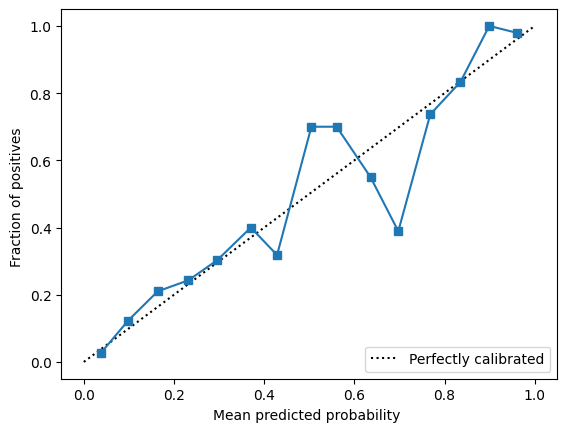

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gradient_boosting = BaseLearner("Gradient Boosting", GradientBoostingClassifier(), train_features, test_features, train_labels, test_labels)

print(gradient_boosting.run_and_score())

print(BaseLearner("Gradient Boosting", GradientBoostingClassifier() , train_features, test_features, train_labels, test_labels, calibrated_method="sigmoid").run_and_score())

print(BaseLearner("Gradient Boosting", GradientBoostingClassifier(), train_features, test_features, train_labels, test_labels, calibrated_method="isotonic").run_and_score())

gradient_boosting.display_reliability(n_bins=15)

# Abstract notes

TLDR: We are running stacking instead of a soft-voting classifier. This allows us to be more expressive in how we combine the models
We would like to have a larger Recall score. Accuracy metric is a misnomer, focus on boosting recall and F1 score. Using final estimator

## Exploratory results

Final Estimator: \
Best Recall: LogReg / RF = 53.8% \
Best F1 Score: LogReg = 62.43% \

Suprise after calibration:  \
SVC (isotonic) Recall = 55.1% \
SVC (isotonic) F1 Score = 62.41%

# Calibration

The main point of calibration is that these "percentages" can then be interpreted better. So that if we have a 80% prediction of rain it actually means it is 80% confident of there being rain, so 4 out of 5 days it would rain with that prediction

Below perfect line means model predictions are overconfident, and calibration will trade off some recall to improve precision.

Above perfect line means model predictions are underconfident, and calibration will trade off some precision to improve recall

## Angular Calibration


Angular calibration as we’ve implemented it really is only meaningful for linear classifiers of the form
Σ(w^⊤ x)
because it needs access to: \
	1.	A coefficient vector w (your coef_) \
	2.	A Gaussian‐design assumption (so you can estimate \|w\|_\Sigma and the angle)

Tree‑based methods (DecisionTree, RandomForest) or kNN don’t expose a global w, so there’s no angle to compute.



In [ ]:
"""
Angular calibration implementation and BaseLearner integration.
"""
import numpy as np
from numpy.polynomial.hermite import hermgauss
from scipy.special import expit

from sklearn.base import BaseEstimator, ClassifierMixin, MetaEstimatorMixin


class AngularCalibrator(ClassifierMixin,  MetaEstimatorMixin, BaseEstimator):
    """
    Angular calibration for binary classifiers.
    Implements get_params/set_params via BaseEstimator.
    Interface matches sklearn CalibratedClassifierCV: fit, predict_proba, predict.
    """
    _estimator_type = "classifier"
    def __init__(self, estimator=None,*, Sigma=None, lam=None, n_quadrature=20):

        self.estimator = estimator
        self.Sigma = Sigma
        self.lam = lam
        self.n_quadrature = n_quadrature

    def fit(self, X_train, y_train, X_sign=None, y_sign=None):
        self.estimator.fit(X_train, y_train)
        # extract model coefficients
        self.w_hat = self.estimator.coef_.ravel()
        # covariance
        if self.Sigma is None:
            self.Sigma = np.cov(X_train, rowvar=False)
        # norm under Sigma
        self.norm_w = np.sqrt(self.w_hat.T @ self.Sigma @ self.w_hat)
        n, d = X_train.shape
        # regularization
        if self.lam is None:
            if hasattr(self.estimator, 'C'):
                self.lam = 1.0 / self.estimator.C
            else:
                raise ValueError("Regularization lam must be provided or estimator.C available.")
        # decision values and derivatives
        u = X_train @ self.w_hat
        p = expit(u)
        psi = p - y_train
        D = p * (1 - p)
        # compute H
        DX = X_train * D[:, None]
        H_inv = X_train.T @ DX + n * self.lam * np.eye(d)
        H = np.linalg.inv(H_inv)
        v = np.trace(np.diag(D) - DX @ H @ DX.T) / n
        gamma = np.trace(X_train @ H @ DX.T)
        r = np.linalg.norm(psi) / np.sqrt(n)
        A = X_train @ self.w_hat - gamma * psi
        # a_hat^2
        num = (v * np.linalg.norm(A) + psi @ A / n)**2
        denom = (np.linalg.norm(X_train.T @ psi)**2 / n**2 +
                 2*v*(psi @ X_train @ self.w_hat)/n +
                 v**2 * np.linalg.norm(A)**2 -
                 (d/n)*r**2)
        a2 = num / denom
        a_hat = np.sqrt(max(a2, 0.0))
        # sign estimation
        sign = 1
        if X_sign is not None and y_sign is not None:
            s = np.sum((X_sign @ self.w_hat) * y_sign)
            sign = 1 if s >= 0 else -1
        # compute cos/sin theta
        cos_theta = sign * (a_hat / self.norm_w)
        self.cos_theta = np.clip(cos_theta, -1.0, 1.0)
        self.sin_theta = np.sqrt(1 - self.cos_theta**2)
        # prepare quadrature
        nodes, weights = hermgauss(self.n_quadrature)
        self.gh_x = nodes * np.sqrt(2)
        self.gh_w = weights / np.sqrt(np.pi)
        return self

    def predict_proba(self, X):
        # raw decision values
        if hasattr(self.estimator, 'decision_function'):
            u = self.estimator.decision_function(X)
        else:
            u = X @ self.w_hat
        # normalize
        u = u / self.norm_w
        # Gauss-Hermite integration
        p = []
        for ui in u:
            vals = expit(self.cos_theta * ui + self.sin_theta * self.gh_x)
            p.append(np.dot(self.gh_w, vals))
        p = np.array(p)
        return np.vstack([1 - p, p]).T

    def predict(self, X):
        proba = self.predict_proba(X)[:,1]
        return (proba >= 0.5).astype(int)

In [ ]:
for name in OG_MODELS.keys():
  BaseLearner(name, OG_MODELS[name], train_features, test_features, train_labels, test_labels).display_reliability(n_bins=25)